<a href="https://colab.research.google.com/github/GwenTsang/SVM/blob/main/Copy_of_20newsgroup_Optuna_SVM_clean_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_20newsgroups
groups = fetch_20newsgroups()

L'option `remove=("headers", "footers", "quotes")` utilisée ci-dessous rend la tâche de classification plus difficile car le modèle ne peut pas "tricher" en regardant l'adresse email de l'expéditeur ou les en-têtes.

In [ ]:
data_train = fetch_20newsgroups(subset="train", remove=("headers","footers","quotes"), random_state=21)
train_label = data_train.target
data_test  = fetch_20newsgroups(subset="test",  remove=("headers","footers","quotes"), random_state=21)
test_label = data_test.target
len(data_train.data), len(data_test.data), len(test_label)

(11314, 7532, 7532)

Il y a 20 classes différentes :

In [ ]:
import numpy as np
np.unique(test_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
import re
from multiprocessing import Pool, cpu_count
from functools import partial

def init_worker():
    global names_set, wnl
    from nltk.corpus import names
    from nltk.stem import WordNetLemmatizer
    names_set = {n.lower() for n in names.words()}
    wnl = WordNetLemmatizer()

def clean_text(text):
    global names_set, wnl
    # Regex
    tokens = re.findall(r'[a-z]{3,}', text.lower())
    words = [wnl.lemmatize(w) for w in tokens if w not in names_set]
    return " ".join(words)

def clean(data):
    with Pool(cpu_count(), initializer=init_worker) as pool:
        return pool.map(clean_text, data, chunksize=100)

In [ ]:
x_test = data_test.data
x_train = data_train.data
len(x_test)
len(x_train)

11314

# **SVM linéaire**


On distingue deux grands types de SVM linéaires : le **Hard margin** SVM et le **Soft margin** SVM.

### SVM **Hard Margin**

Dans le premier, les instances doivent être parfaitement séparables par un hyperplan linéaire.

Pour les points $x_i$ dans la classe $y_i = 1$ on impose :
$$\omega^\top x_i + b \ge 1$$

Pour les points $x_i$ dans la classe $y_i = -1$ on impose :
$$\omega^\top x_i + b \le -1$$

On constate qu'un élément $x_i$ est bien classifié si $y_i$ et $(\omega^\top x_i + b)$ ont le même signe. Ainsi, on peut reformuler ces deux contraintes de manière unifiée :
$$\boxed{\forall i,\quad y_i \cdot (\omega^\top x_i + b) \ge 1}$$


Mais cela suppose que les données soient parfaitement linéairement séparables.

Si ce n'est pas le cas, alors, quel que soit l’hyperplan choisi, il existera au moins un point $x_i$ pour lequel $y_i \cdot (\omega^\top x_i + b) \le 0$ c’est-à-dire au moins un point mal classé (ce qui arrive si $y_i$ et $(\omega^\top x_i + b)$ ont des signes différents), ou situé sur la frontière de décision (ce qui arrive si $y_i \cdot (\omega^\top x_i + b) = 0$).

Formellement, c'est linéairement séparable si

$$\exists (\omega,b)\ \text{tel que}\ \forall i,\ y_i(\omega^\top x_i + b) > 0$$


et non linéairement séparable si :

$$\forall (\omega,b),\ \exists i\ \text{tel que}\ y_i(\omega^\top x_i + b) \le 0$$

### SVM **Soft Margin**

C'est ce pourquoi on utilise un **SVM linéaire soft margin** qui fonctionne même si les données ne sont pas parfaitement linéairement séparables en tolérant des écarts et donc des erreurs de classifications éventuelles.

De manière générale, dans un SVM, il faut maximiser l'espacement entre les deux marges (qui correspondent aux deux hyperplans $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = 1 \}$ et $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = -1 \}$). Mais, avec certaines données non linéairement séparables, il faut trouver un compromis entre la largeur de la marge et les erreurs de classification.

Dans un SVM soft margin, on associe à chaque point $x_i$ une quantité $\xi_i$ qui indique “de combien il manque” pour satisfaire la condition idéale $y_i(\omega^\top x_i + b) \ge 1$. Pour chaque point $x_i$, la quantité $\xi_i$ est donnée par :

$$\xi_i = \max(0, 1 - y_i (\omega^\top x_i + b))$$

Il y a trois cas possibles (bien classé, dans la marge, mal classé) :

* Si le point $x_i$ est bien classé :

$$
y_i (\omega^\top x_i + b) \ge 1
\quad\Rightarrow\quad
\big[1 - y_i (\omega^\top x_i + b)\big] \le 0
\quad\Rightarrow\quad
\xi_i = 0
$$

* Si le point $x_i$ est dans la marge (entre les deux hyperplans) mais correctement classé :

$$
0 < y_i (\omega^\top x_i + b) < 1
\quad\Rightarrow\quad
0 < \xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] < 1
$$

* Si le point $x_i$ est mal classé :

$$
y_i (\omega^\top x_i + b) < 0
\quad\Rightarrow\quad
\xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] > 1
$$

Maintenant, on peut pénaliser le modèle à la fois en fonction du nombre de points du mauvais côté (en comptant à la fois les points dans les marges bien classés et ceux qui sont mal classés) et de l'ampleur des violations (plus la position d'un point s'écarte de sa position attendue, plus la pénalité sur la loss sera forte).

### **Comparaison de [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et de [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)**

Dans `LinearSVC` de Scikitlearn, on peut régler le compromis entre la largeur de la marge et les erreurs sur l’échantillon grâce à l'hyperparamètre $C$.

Si $C$ est grand, on cherche à réduire au maximum ces erreurs quitte à avoir une marge plus petite ; si $C$ est petit, on tolère davantage les violations pour favoriser une marge plus large.

Sur `SGDClassifier` l'hyperparamètre "alpha" joue un rôle équivalent

SGDClassifier avec loss='hinge' = SVM linéaire



## **Quel optimiseur d'hyperparamètres choisir ?**

On présente ci-dessous trois méthodes pour rechercher les hyperparamètres optimaux :

### 1. **GridSearch**
**[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)** effectue une recherche ***exhaustive*** : il teste *toutes* les combinaisons possibles dans des grilles d'hyperparamètres prédéfinies.
Bien qu'on ait la garantie de trouver l'optimum global dans l'espace discret prédéfini, le temps et le coût computationnel peuvent vite devenir très élevés en fonction de la taille de l'espace des valeurs possibles.

### 2. **RandomizedSearchCV**

Au lieu d’essayer toutes les combinaisons possibles de paramètres,
[`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) choisit ***au hasard*** un certain nombre (prédéfini) de combinaisons de paramètres. Il évalue chacune de ces combinaisons avec une validation croisée. Puis, finalement, il retient la combinaison qui donne les meilleurs résultats.

### 3. **Optuna**
**[`Optuna`](https://pypi.org/project/optuna/)** utilise une recherche ***bayésienne*** (algorithme TPE - Tree-structured Parzen Estimator) en échantillonnant l'espace des hyperparamètres et en privilégiant les régions prometteuses identifiées par les évaluations précédentes. Cela permet d'obtenir de bonnes solutions avec moins d'itérations. C'est pas absolument nécessaire ici mais dans certains cas où les espaces d'hyperparamètres à tester sont de très grande dimension et continus c'est plus rapide et efficace.

# Méthodologie

Puisqu'on ne sait pas trop quoi choisir entre [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et  [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), nous allons tester une optimisation des hyperparamètres avec les deux dans la section 3.

Pour que ce soit vraiment comparable, on va essayer de faire vraiment l'équivalent des deux côtés.

Mais avant cela, il faut procéder à une étape de vectorisation.

## **Vectorisation avec TF-IDF**

#### **Suppression des stop-words**

Scikit-learn possède un fichier interne qui contient une liste fixe de mots anglais considérés comme des `stop_words` . Comme ils le font dans les codes proposé sur leur site (par exemple [ce code](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html) ou encore [ce code](https://scikit-learn.org/0.21/auto_examples/text/plot_document_classification_20newsgroups.html)), on enlève les `stop_words` présents dans le corpus. On peut afficher le nombre de ces `stop_words` et les inspecter manuellement avec :

```python
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(len(ENGLISH_STOP_WORDS))
print(list(ENGLISH_STOP_WORDS))
```

Commençons par computer toutes les matrices TF-IDF qui vont être utilisées, de manière à éviter de les re-calculer. La cellule qui suit prend quelques minutes à s'executer et prend un certain espace dans la RAM, mais elle permettra de gagner du temps lors des étapes d'optimisation des hyperparamètres juste après.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from itertools import product
import numpy as np

# Valeurs discrètes pour le cache avec step=4000 pour max_features TF-IDF
MAX_FEATURES_VALUES = [10000, 15000, 20000, 25000, 30000]
MAX_DF_VALUES = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def precompute_tfidf(texts_train, texts_test, max_feats, max_df_vals, n_jobs=-1):
    """
    Pré-calcule les matrices TF-IDF pour toutes les combinaisons.
    Stocke aussi le vectorizer pour transformer les données de test.
    """
    def fit(mf, mdf):
        vec = TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_features=mf,
            max_df=mdf,
            dtype=np.float32
        )
        X_train = vec.fit_transform(texts_train)
        X_test = vec.transform(texts_test)
        return (mf, mdf), {
            'vectorizer': vec,
            'X_train': X_train,
            'X_test': X_test
        }

    results = Parallel(n_jobs=n_jobs)(
        delayed(fit)(mf, mdf)
        for mf, mdf in product(max_feats, max_df_vals)
    )
    return dict(results)

# Pré-calcul (exécuté une seule fois)
print(f"Pré-calcul de {len(MAX_FEATURES_VALUES) * len(MAX_DF_VALUES)} matrices TF-IDF")
tfidf_cache = precompute_tfidf(
    x_train, x_test,
    MAX_FEATURES_VALUES,
    MAX_DF_VALUES
)
print(f"Cache créé avec {len(tfidf_cache)} entrées.")

Pré-calcul de 30 matrices TF-IDF...
Cache créé avec 30 entrées.


In [ ]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 24.1 MB/s eta 0:00:00


On utilise un système de pruning.
La [documentation d'Optuna](https://optuna.readthedocs.io/en/stable/reference/pruners.html) détaille les différents systèmes de pruning utilisables.
On utilise ici `pruner=optuna.pruners.MedianPruner(n_startup_trials=5)`

 ⚠️ On n'utilise pas le jeu de test (ici (`x_test`, `test_label`)) pour optimiser les hyperparamètres pour éviter de biaiser l'évaluation finale ([data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning))).


 Ainsi, dans les deux codes pythons qui suivent, on utilise une **Cross Validation**

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import optuna
import time

def create_objective_fast_cached(y, tfidf_cache, cv=3):
    """Réutilisation du cache TF-IDF pré-calculé."""
    def objective(trial):
        # Utiliser suggest_categorical pour correspondre exactement au cache
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        alpha = trial.suggest_float('alpha', 1e-4, 1e-2, log=True)

        # Récupération de la matrice pré-calculée (économie de compute !)
        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = SGDClassifier(
            loss='hinge',
            alpha=alpha,
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )

        # Mesure du temps d'exécution
        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score

    return objective

def run_optuna_fast_cached(y, tfidf_cache, n_trials=30, cv=3):
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
    )
    objective = create_objective_fast_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)
    return study

# Lancement
study_sgd = run_optuna_fast_cached(train_label, tfidf_cache, n_trials=30)

print(f"\n[SGDClassifier] Meilleurs paramètres : {study_sgd.best_params}")
print(f"[SGDClassifier] Meilleur score CV : {study_sgd.best_value:.4f}")

[I 2025-12-14 09:46:50,001] A new study created in memory with name: no-name-309e6d50-37da-409e-a0a9-6d6e082e832d


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-14 09:46:51,015] Trial 0 finished with value: 0.7168108386836005 and parameters: {'max_features': 15000, 'max_df': 0.7, 'alpha': 0.008706020878304856}. Best is trial 0 with value: 0.7168108386836005.
[I 2025-12-14 09:46:52,305] Trial 1 finished with value: 0.7146892683170546 and parameters: {'max_features': 10000, 'max_df': 0.8, 'alpha': 0.0005404103854647331}. Best is trial 0 with value: 0.7168108386836005.
[I 2025-12-14 09:46:53,960] Trial 2 finished with value: 0.7170759265961446 and parameters: {'max_features': 15000, 'max_df': 1.0, 'alpha': 0.004138040112561018}. Best is trial 2 with value: 0.7170759265961446.
[I 2025-12-14 09:46:55,864] Trial 3 finished with value: 0.7223792315056422 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.001096821720752952}. Best is trial 3 with value: 0.7223792315056422.
[I 2025-12-14 09:46:57,710] Trial 4 finished with value: 0.7296266394229782 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.0004473636174

On veut maintenant faire la même chose avec `LinearSVC`.

Dans la cellule ci-dessous on utilise une formule qui permet de trouver les équivalences entre l'hyperparamètre $C$ de LinearSVC et l'hyperparamètre $alpha$ de SGCDClassifier (formule donnée dans https://scikit-learn.org/stable/modules/linear_model.html#comparison-with-the-regularization-parameter-of-svm )

In [ ]:
n_samples = len(x_test)
alpha_min = 1e-4
alpha_max = 1e-2

# Application de la formule
c_max_equivalent = 1 / (n_samples * alpha_min)
c_min_equivalent = 1 / (n_samples * alpha_max)

print(f"Pour alpha={alpha_max} C équivalent ≈ {c_min_equivalent:.5f}")
print(f"Pour alpha={alpha_min} C équivalent ≈ {c_max_equivalent:.5f}")

Pour alpha=0.01 C équivalent ≈ 0.01328
Pour alpha=0.0001 C équivalent ≈ 1.32767


[I 2025-12-14 09:48:35,469] A new study created in memory with name: no-name-a4eafbc0-d26d-4e3f-9ab1-c7313226f8cb


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-14 09:48:37,822] Trial 1 finished with value: 0.7444755229088731 and parameters: {'max_features': 25000, 'max_df': 1.0, 'C': 0.24518046945879976}. Best is trial 1 with value: 0.7444755229088731.
[I 2025-12-14 09:48:39,523] Trial 0 finished with value: 0.7408520767266404 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.8511108753477181}. Best is trial 1 with value: 0.7444755229088731.
[I 2025-12-14 09:48:42,042] Trial 2 finished with value: 0.7330741649051163 and parameters: {'max_features': 20000, 'max_df': 0.6, 'C': 1.0461073587740328}. Best is trial 1 with value: 0.7444755229088731.
[I 2025-12-14 09:48:42,913] Trial 3 finished with value: 0.7263564875626619 and parameters: {'max_features': 10000, 'max_df': 0.7, 'C': 0.23041999146369826}. Best is trial 1 with value: 0.7444755229088731.
[I 2025-12-14 09:48:44,606] Trial 4 finished with value: 0.742177539723583 and parameters: {'max_features': 20000, 'max_df': 0.7, 'C': 0.31978943461322246}. Best is trial 1 with 

/tmp/ipython-input-1575324014.py:49: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_optimization_history(study_large)


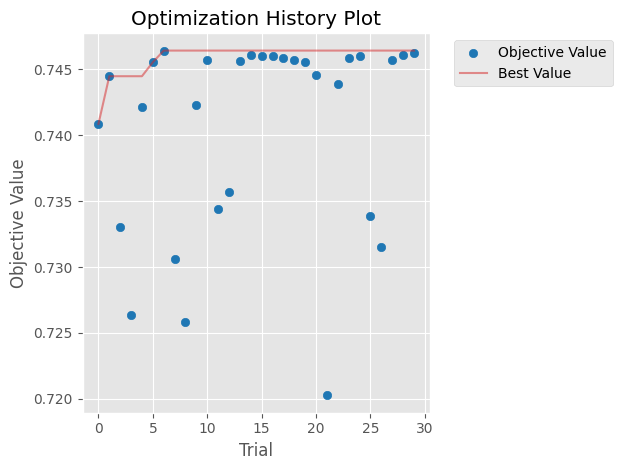

/tmp/ipython-input-1575324014.py:52: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_slice(study_large, params=["max_features"])


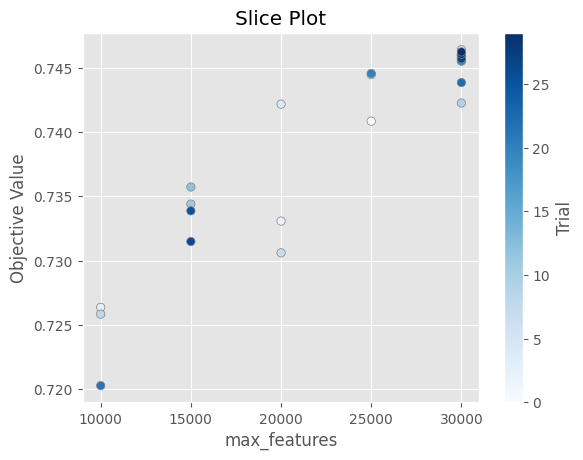

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import optuna
import optuna.visualization.matplotlib as vis_mpl
import matplotlib.pyplot as plt
import time

def create_objective_large_cached(y, tfidf_cache, cv=3):
    """Réutilisation du cache TF-IDF pré-calculé."""
    def objective(trial):
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        C = trial.suggest_float('C', 0.1, 1.3, log=True)

        # Récupération de la matrice pré-calculée
        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = LinearSVC(C=C, dual=True, max_iter=2000, random_state=42)

        # Mesure du temps
        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score

    return objective

def run_optuna_large_cached(y, tfidf_cache, n_trials=40, cv=3):
    study = optuna.create_study(direction='maximize')
    objective = create_objective_large_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)
    return study

# Lancement
study_large = run_optuna_large_cached(train_label, tfidf_cache, n_trials=30)

print(f"\n[LinearSVC] Meilleurs paramètres : {study_large.best_params}")
print(f"[LinearSVC] Meilleur score CV : {study_large.best_value:.4f}")

print("\n[Importance des hyperparamètres]")
importances = optuna.importance.get_param_importances(study_large)
for param, importance in importances.items():
    print(f"{param} : {importance:.4f}")


# Visualisations

vis_mpl.plot_optimization_history(study_large)
plt.show()

vis_mpl.plot_slice(study_large, params=["max_features"])
plt.show()

### **Résultats**

Le troisième graphique suggère que plus la dimensionalité des vecteurs TF-IDF est grande (plus l'hyperparamètre `max_features` est élevé), plus la performance est élevée.

On constate qu'au global, dans cette optimisation des hyperparamètres, la méthode `LinearSVC` prend un tout petit peu plus de temps que la méthode `SGDClassifier`.  Puisqu'on vient de sauvegarder tous les temps d'éxécution, on peut faire une régression pour voir quels sont les hyperparamètres qui influencent le plus le temps d'éxécution.

### **Quel paramètre influence le plus le temps d'éxécution ?**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import polars as pl

def analyze_duration_importance(study, features, name):
    """Analyse de l'impact des features sur le temps d'exécution."""
    df = pl.DataFrame([
        t.params | {'duration': t.user_attrs['duration']}
        for t in study.trials if t.state.name == "COMPLETE"
    ])

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df[features], df["duration"])

    importance = sorted(
        zip(features, rf.feature_importances_.tolist()),
        key=lambda x: x[1],
        reverse=True
    )
    print(f"\n{name} Influence des features sur le temps d'exécution:")
    for feat, imp in importance:
        print(f"  {feat}: {imp:.4f}")

# Analyse
analyze_duration_importance(study_sgd, ["max_features", "max_df", "alpha"], "SGDClassifier")
analyze_duration_importance(study_large, ["max_features", "max_df", "C"], "LinearSVC")


SGDClassifier Influence des features sur le temps d'exécution:
  alpha: 0.8313
  max_df: 0.1303
  max_features: 0.0384

LinearSVC Influence des features sur le temps d'exécution:
  C: 0.6806
  max_df: 0.1860
  max_features: 0.1334


Ces résultats corroborent certaines de nos expériences dans lesquelles, lorsqu'on lançait un trial `LinearSVC` avec une valeur de $C$ élevée, cela prenait très longtemps à converger ou bien cela ne convergeait pas.